# Module 1: 基础设置与依赖库 (Setup)


In [9]:
import os

# ==== 你的配置 ====
DATA_PATH = "data/EOG_data"
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]

print(f"📂 当前工作目录 (Current Working Directory): {os.getcwd()}")
print(f"🔍 正在寻找数据目录: {os.path.abspath(DATA_PATH)}")

# 1. 检查主目录是否存在
if not os.path.exists(DATA_PATH):
    print(f"❌ 错误：找不到文件夹 '{DATA_PATH}'")
    print("   -> 请检查你的文件夹名字是否写对？")
    print("   -> 请检查该文件夹是否和你的 .ipynb 文件在同一个目录下？")
else:
    print(f"✅ 找到主目录！其中的内容有: {os.listdir(DATA_PATH)}")
    
    # 2. 检查子文件夹
    total_csv_count = 0
    for label in CLASSES:
        sub_folder = os.path.join(DATA_PATH, label)
        if not os.path.exists(sub_folder):
            print(f"⚠️ 警告：找不到子文件夹 '{label}' (代码期望路径: {sub_folder})")
        else:
            # 3. 检查 CSV 文件
            files = [f for f in os.listdir(sub_folder) if f.endswith(".csv")]
            print(f"   📂 '{label}' 文件夹里有 {len(files)} 个 CSV 文件")
            total_csv_count += len(files)
            
            # 4. 检查文件内容 (抽查第一个)
            if len(files) > 0:
                first_file = os.path.join(sub_folder, files[0])
                try:
                    df = pd.read_csv(first_file, header=0, nrows=5)
                    print(f"      🔎 抽查 {files[0]}: 列名={list(df.columns)}")
                except Exception as e:
                    print(f"      ❌ 读取失败: {e}")

    if total_csv_count == 0:
        print("\n❌ 结论：路径下确实没有 .csv 文件。请检查文件后缀是否大写了 (.CSV)?")

📂 当前工作目录 (Current Working Directory): d:\xukun\Documents\IC\AML_lab\AML_lab_gitpull
🔍 正在寻找数据目录: d:\xukun\Documents\IC\AML_lab\AML_lab_gitpull\data\EOG_data
✅ 找到主目录！其中的内容有: ['Blink', 'Down', 'Left', 'Rest', 'Right', 'Up']
   📂 'Rest' 文件夹里有 0 个 CSV 文件
   📂 'Up' 文件夹里有 0 个 CSV 文件
   📂 'Down' 文件夹里有 0 个 CSV 文件
   📂 'Left' 文件夹里有 0 个 CSV 文件
   📂 'Right' 文件夹里有 0 个 CSV 文件
   📂 'Blink' 文件夹里有 0 个 CSV 文件

❌ 结论：路径下确实没有 .csv 文件。请检查文件后缀是否大写了 (.CSV)?


In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 绘图风格设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import signal
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==== 全局配置 ====
DATA_PATH = "data/EOG_data"  # 请确保您的数据在这个目录下
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]
TARGET_FS = 50   # 目标采样率 50Hz
WINDOW_SIZE = 50 # 窗口大小 (1秒)
STEP_SIZE = 10   # (仅用于Rest的滑动步长)

# Module 2: 数据载入 (Data Loading)

🚀 Loading data from EOG_data...
✅ Loaded 73 files.


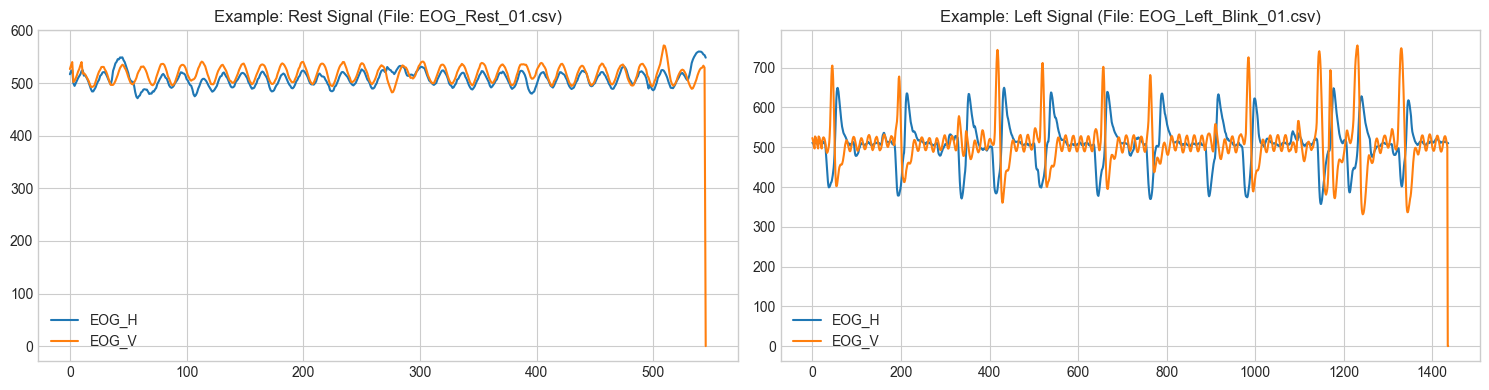

In [10]:
# Cell 2: Data Loading Function

# ==== 配置区域 ====
DATA_PATH = "EOG_data"  # 你的数据路径
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]
SAMPLING_RATE = 50  # 假设采样率 50Hz (delay 20ms)

def load_raw_data():
    raw_data = [] # 存放波形 (N, 2)
    labels = []   # 存放标签 ID
    filenames = [] # 存放文件名方便debug

    print(f"🚀 Loading data from {DATA_PATH}...")
    
    for label_name in CLASSES:
        folder_path = os.path.join(DATA_PATH, label_name)
        if not os.path.exists(folder_path):
            continue
            
        csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
        
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            try:
                # 读取指定的列 (根据你之前的截图)
                df = pd.read_csv(file_path, header=0, usecols=['data 0', 'data 1'])
                df.columns = ['EOG_H', 'EOG_V'] # 重命名
                
                # 转为数值并去空
                df = df.apply(pd.to_numeric, errors='coerce').dropna()
                
                # 简单清洗：丢弃太短的文件 (<1秒)
                if len(df) < SAMPLING_RATE:
                    continue
                    
                raw_data.append(df.values)
                labels.append(CLASSES.index(label_name))
                filenames.append(file)
                
            except Exception as e:
                print(f"❌ Error reading {file}: {e}")

    print(f"✅ Loaded {len(raw_data)} files.")
    return raw_data, np.array(labels), filenames

# 执行加载
X_raw_list, y_raw_list, filenames = load_raw_data()

# 画个图检查一下 Rest 和 Action 的区别
plt.figure(figsize=(15, 4))

# 1. 画 Rest 信号
# np.where 返回满足条件的索引列表
rest_indices = np.where(y_raw_list == 0)[0] 

if len(rest_indices) > 0:
    idx_rest = rest_indices[0] # 取第一个 Rest 样本的索引
    plt.subplot(1, 2, 1)
    plt.plot(X_raw_list[idx_rest]) # 使用整数索引去访问列表
    plt.title(f"Example: Rest Signal (File: {filenames[idx_rest]})")
    plt.legend(['EOG_H', 'EOG_V'])
else:
    print("⚠️ Warning: No 'Rest' data found to plot.")

# 2. 画 Left 信号 (假设 Left 是第 3 类，根据你的CLASSES顺序)
# CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"] -> Left is index 3
left_indices = np.where(y_raw_list == 3)[0]

if len(left_indices) > 0:
    idx_left = left_indices[0] # 取第一个 Left 样本的索引
    plt.subplot(1, 2, 2)
    plt.plot(X_raw_list[idx_left])
    plt.title(f"Example: Left Signal (File: {filenames[idx_left]})")
    plt.legend(['EOG_H', 'EOG_V'])
else:
    print("⚠️ Warning: No 'Left' data found to plot.")

plt.tight_layout()
plt.show()

In [11]:
def load_raw_data():
    raw_data = [] 
    labels = []   
    filenames = [] 
    
    print(f"🚀 Loading and Resampling data to {TARGET_FS}Hz...")
    
    for label_name in CLASSES:
        folder_path = os.path.join(DATA_PATH, label_name)
        if not os.path.exists(folder_path):
            continue
            
        csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
        
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            try:
                # 1. 读取原始数据
                df = pd.read_csv(file_path, header=0, usecols=['Program Time [s]', 'data 0', 'data 1'])
                df.columns = ['Time', 'EOG_H', 'EOG_V']
                df = df.apply(pd.to_numeric, errors='coerce').dropna()
                
                if len(df) < 10: continue 

                # ==== 核心修复：降采样 (Downsampling) ====
                duration = df['Time'].iloc[-1] - df['Time'].iloc[0]
                if duration <= 0: continue
                real_fs = len(df) / duration
                
                # 如果原始采样率远高于 50Hz，进行重采样
                if real_fs > TARGET_FS + 5: # 留一点容差
                    num_samples = int(duration * TARGET_FS)
                    if num_samples < WINDOW_SIZE: continue 
                    
                    resampled_h = signal.resample(df['EOG_H'].values, num_samples)
                    resampled_v = signal.resample(df['EOG_V'].values, num_samples)
                    processed_data = np.column_stack((resampled_h, resampled_v))
                else:
                    processed_data = df[['EOG_H', 'EOG_V']].values

                raw_data.append(processed_data)
                labels.append(CLASSES.index(label_name))
                filenames.append(file)
                
            except Exception as e:
                print(f"❌ Error reading {file}: {e}")

    print(f"✅ Loaded & Resampled {len(raw_data)} files.")
    return raw_data, np.array(labels), filenames

# 执行加载
X_raw_list, y_raw_list, filenames = load_raw_data()

🚀 Loading and Resampling data to 50Hz...
✅ Loaded & Resampled 73 files.


# Module 3: 数据预处理 (Preprocessing & Filtering)

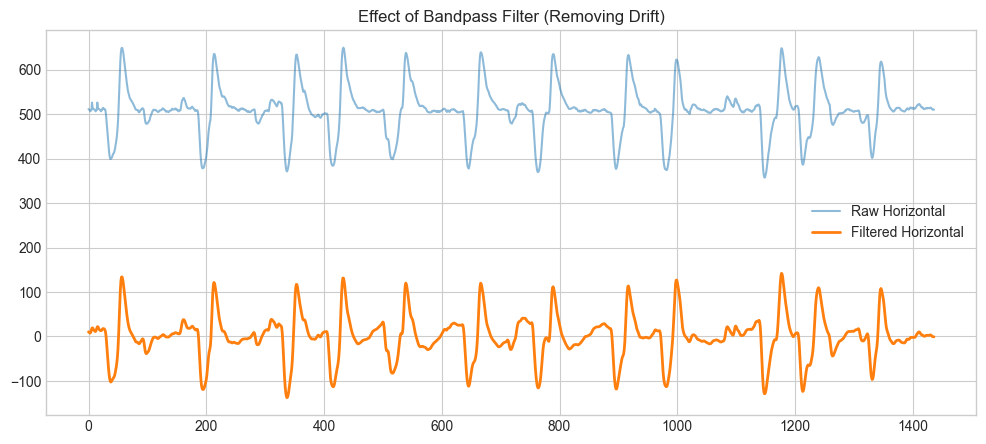

In [4]:
# Cell 3: Preprocessing (Bandpass Filter)

def apply_filter(data, lowcut=0.5, highcut=10.0, fs=50, order=4):
    """
    带通滤波器：
    - 去除 < 0.5Hz 的基线漂移 (非常重要！)
    - 去除 > 10Hz 的高频肌电噪音
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

X_filtered_list = [apply_filter(d) for d in X_raw_list]

# 可视化滤波效果 (对比)
idx = np.where(y_raw_list == 3)[0][0] # 找一个 Left 的样本
plt.figure(figsize=(12, 5))
plt.plot(X_raw_list[idx][:, 0], label='Raw Horizontal', alpha=0.5)
plt.plot(X_filtered_list[idx][:, 0], label='Filtered Horizontal', linewidth=2)
plt.title("Effect of Bandpass Filter (Removing Drift)")
plt.legend()
plt.show()

In [12]:
def apply_filter(data, lowcut=0.5, highcut=10.0, fs=50, order=4):
    """
    带通滤波器：去除基线漂移(<0.5Hz) 和 高频噪音(>10Hz)
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

# 批量滤波
X_filtered_list = [apply_filter(d) for d in X_raw_list]
print("✅ Filtering complete.")

✅ Filtering complete.


# Module 4: 特征工程 (Advanced Feature Extraction)

In [11]:
# Cell 4: Windowing & Feature Extraction

WINDOW_SIZE = 50  # 1秒窗口
STEP_SIZE = 10    # 滑动步长

# 修改 Module 4 中的 extract_features 函数

def extract_features(data_list, label_list):
    X_feat = []
    y_feat = []
    
    # 设定一个清洗阈值
    # 你可以根据刚才的图来看，真正的波峰都在 100 以上，噪音都在 50 以下
    # 所以设定 50-80 是比较合理的
    CLEANING_THRESHOLD = 60.0 
    
    for i, data in enumerate(data_list):
        original_label = label_list[i]
        
        # 滑动窗口
        for start in range(0, len(data) - WINDOW_SIZE, STEP_SIZE):
            window = data[start:start+WINDOW_SIZE]
            
            # --- 1. 计算峰峰值 (P2P) ---
            # 我们主要看水平(H)和垂直(V)两个通道谁的动静大
            ptp_h = np.max(window[:, 0]) - np.min(window[:, 0])
            ptp_v = np.max(window[:, 1]) - np.min(window[:, 1])
            max_ptp = max(ptp_h, ptp_v)
            
            # --- 2. 标签清洗核心逻辑 (The Fix) ---
            # 如果波形太平，即使它来自 'Left' 文件夹，我们也把它标记为 'Rest' (0)
            # 假设 Rest 的 label ID 是 0
            if max_ptp < CLEANING_THRESHOLD:
                current_label = 0 # 强制改为 Rest
            else:
                current_label = original_label # 保留原始标签

            # --- 3. 提取特征 (保持不变) ---
            row_features = []
            for axis in range(2): 
                sig = window[:, axis]
                row_features.append(np.std(sig))    
                row_features.append(np.max(sig) - np.min(sig)) 
                diff = np.diff(sig)
                row_features.append(np.mean(np.abs(diff))) 
                row_features.append(np.max(np.abs(diff)))
                row_features.append(skew(sig)) 
                row_features.append(kurtosis(sig))
                row_features.append(np.sum(sig**2))

            X_feat.append(row_features)
            y_feat.append(current_label) # 注意这里 append 的是清洗后的标签
            
    return np.array(X_feat), np.array(y_feat)
print("Extracting features...")
X, y = extract_features(X_filtered_list, y_raw_list)
print(f"Feature Matrix Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Extracting features...
Feature Matrix Shape: (14998, 14)
Labels Shape: (14998,)


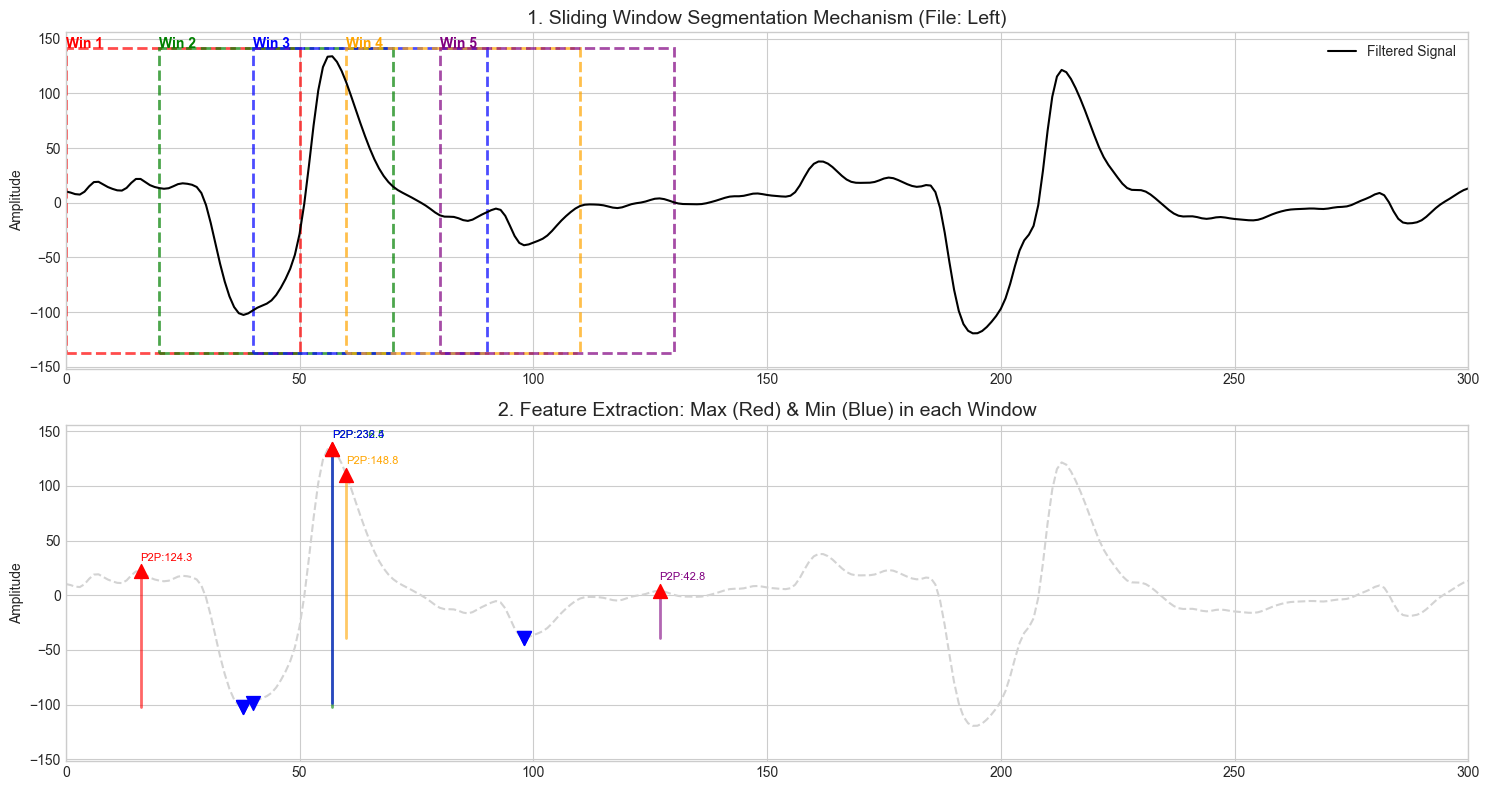

In [13]:
import matplotlib.patches as patches

# ==== 1. 随便选一个动作文件来演示 ====
# 假设我们选 'Left' 文件夹里的第一个文件
target_label = "Left"
file_idx = 0 
target_file = os.path.join(DATA_PATH, target_label, 
                           os.listdir(os.path.join(DATA_PATH, target_label))[file_idx])

# 读取并滤波 (使用之前的 apply_filter 函数)
df = pd.read_csv(target_file, header=0, usecols=['data 0', 'data 1'])
df.columns = ['EOG_H', 'EOG_V']
raw_signal = df['EOG_H'].values # 我们只看水平信号演示
filtered_signal = apply_filter(raw_signal.reshape(-1, 1)).flatten()

# ==== 2. 可视化设置 ====
WINDOW_SIZE = 50
STEP_SIZE = 20 # 步长设大一点方便看清楚

plt.figure(figsize=(15, 8))

# --- 子图 1: 展示滑动窗口是如何“暴力切分”的 ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(filtered_signal, color='black', linewidth=1.5, label='Filtered Signal')
ax1.set_title(f"1. Sliding Window Segmentation Mechanism (File: {target_label})", fontsize=14)

# 画出前 5 个窗口
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i in range(5):
    start = i * STEP_SIZE
    end = start + WINDOW_SIZE
    
    # 在图上画框
    rect = patches.Rectangle((start, min(filtered_signal)), WINDOW_SIZE, max(filtered_signal)-min(filtered_signal), 
                             linewidth=2, edgecolor=colors[i], facecolor='none', alpha=0.7, linestyle='--')
    ax1.add_patch(rect)
    ax1.text(start, max(filtered_signal), f"Win {i+1}", color=colors[i], fontweight='bold')

ax1.set_xlim(0, 300) # 只看前300个点
ax1.set_ylabel("Amplitude")
ax1.legend(loc='upper right')

# --- 子图 2: 展示峰值特征提取 (Peak-to-Peak) ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(filtered_signal, color='lightgray', linestyle='--')
ax2.set_title("2. Feature Extraction: Max (Red) & Min (Blue) in each Window", fontsize=14)

# 对刚才那 5 个窗口提取特征并画点
for i in range(5):
    start = i * STEP_SIZE
    end = start + WINDOW_SIZE
    window_data = filtered_signal[start:end]
    
    # 找到窗口内的最大值和最小值的索引
    # 注意：argmax 返回的是相对窗口的索引，需要加上 start 才是全局索引
    max_idx = np.argmax(window_data) + start
    min_idx = np.argmin(window_data) + start
    
    # 画出特征点
    ax2.scatter(max_idx, filtered_signal[max_idx], color='red', s=100, zorder=5, marker='^') # Max
    ax2.scatter(min_idx, filtered_signal[min_idx], color='blue', s=100, zorder=5, marker='v') # Min
    
    # 画连接线表示 "Peak-to-Peak Amplitude"
    ax2.plot([max_idx, max_idx], [filtered_signal[min_idx], filtered_signal[max_idx]], 
             color=colors[i], linestyle='-', linewidth=2, alpha=0.6)
    
    # 标注数值
    ptp_value = filtered_signal[max_idx] - filtered_signal[min_idx]
    ax2.text(max_idx, filtered_signal[max_idx]+10, f"P2P:{ptp_value:.1f}", fontsize=8, color=colors[i])

ax2.set_xlim(0, 300)
ax2.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

✂️ Segmenting data...
✅ Created 1098 aligned segments. Shape: (1098, 50, 2)
2. Visualizing data quality...


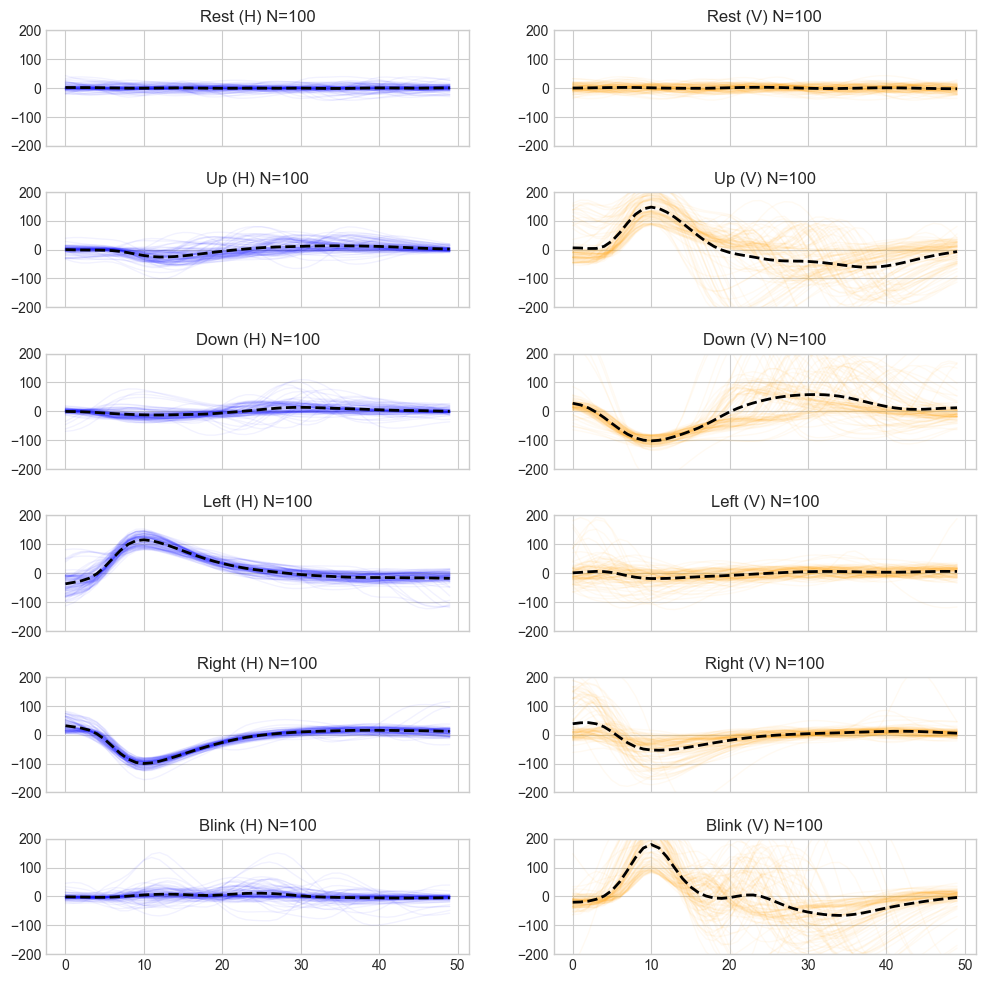

In [20]:
def segment_data_by_peaks_final(data_list, label_list):
    """
    基于峰值对齐的切分逻辑：
    - Left/Up 只找正峰值
    - Right/Down 只找负峰值
    - Rest 使用滑动窗口 + 阈值清洗
    """
    segments = []
    labels = []
    
    # ==== 参数配置 ====
    PRE_BUFFER = 10    # 峰值前留多少点
    HEIGHT_THRES = 80  # 动作阈值 (绝对值)
    DISTANCE = 40      # 峰值间距
    
    for i, data in enumerate(data_list):
        label_idx = label_list[i]
        label_name = CLASSES[label_idx]
        
        # 1. Rest 处理逻辑 (保持不变)
        if label_name == "Rest":
            for start in range(0, len(data) - WINDOW_SIZE, WINDOW_SIZE): # 不重叠
                window = data[start:start+WINDOW_SIZE]
                ptp = np.max(window) - np.min(window)
                if ptp < 80: # 只要安静的
                    segments.append(window)
                    labels.append(label_idx)
            continue

        # 2. Action 处理逻辑：极性过滤
        target_peaks = []
        
        if label_name == "Left":
            # Left 是水平正波 -> H通道正峰值
            p, _ = find_peaks(data[:, 0], height=HEIGHT_THRES, distance=DISTANCE)
            target_peaks = p
        elif label_name == "Right":
            # Right 是水平负波 -> H通道负峰值 (取反找峰)
            p, _ = find_peaks(-data[:, 0], height=HEIGHT_THRES, distance=DISTANCE)
            target_peaks = p
        elif label_name == "Up":
            # Up 是垂直正波 -> V通道正峰值
            p, _ = find_peaks(data[:, 1], height=HEIGHT_THRES, distance=DISTANCE)
            target_peaks = p
        elif label_name == "Down":
            # Down 是垂直负波 -> V通道负峰值
            p, _ = find_peaks(-data[:, 1], height=HEIGHT_THRES, distance=DISTANCE)
            target_peaks = p
        elif label_name == "Blink":
            # Blink 通常是垂直正波
            p, _ = find_peaks(data[:, 1], height=HEIGHT_THRES, distance=DISTANCE)
            target_peaks = p

        # 3. 执行切分
        for peak_idx in target_peaks:
            start_idx = peak_idx - PRE_BUFFER
            end_idx = start_idx + WINDOW_SIZE
            
            if start_idx < 0 or end_idx > len(data): continue
                
            window = data[start_idx : end_idx]
            
            # 双重保险：再次检查幅度
            ptp = np.max(window) - np.min(window)
            if ptp > HEIGHT_THRES:
                segments.append(window)
                labels.append(label_idx)

    return np.array(segments), np.array(labels)

# 执行切分
print("✂️ Segmenting data...")
X_segments, y_segments = segment_data_by_peaks_final(X_filtered_list, y_raw_list)
print(f"✅ Created {len(X_segments)} aligned segments. Shape: {X_segments.shape}")

# === 第二步：画图检查 (Data Inspector) ===
print("2. Visualizing data quality...")
import matplotlib.pyplot as plt

def inspect_data_quality(X_segments, y_labels, class_names, num_samples=100):
    unique_labels = np.unique(y_labels)
    n_classes = len(unique_labels)
    
    fig, axes = plt.subplots(n_classes, 2, figsize=(12, 2 * n_classes), sharex=True)
    plt.subplots_adjust(hspace=0.4)
    
    for idx, label_id in enumerate(unique_labels):
        indices = np.where(y_labels == label_id)[0]
        if len(indices) > num_samples:
            indices = np.random.choice(indices, num_samples, replace=False)
            
        current_data = X_segments[indices]
        class_name = class_names[label_id] if label_id < len(class_names) else str(label_id)
        
        # Horizontal
        ax_h = axes[idx, 0]
        ax_h.plot(current_data[:, :, 0].T, color='blue', alpha=0.05, linewidth=1) 
        ax_h.plot(np.mean(current_data[:, :, 0], axis=0), color='black', linewidth=2, linestyle='--')
        ax_h.set_title(f"{class_name} (H) N={len(indices)}")
        ax_h.set_ylim(-200, 200)

        # Vertical
        ax_v = axes[idx, 1]
        ax_v.plot(current_data[:, :, 1].T, color='orange', alpha=0.05, linewidth=1)
        ax_v.plot(np.mean(current_data[:, :, 1], axis=0), color='black', linewidth=2, linestyle='--')
        ax_v.set_title(f"{class_name} (V) N={len(indices)}")
        ax_v.set_ylim(-200, 200)
    plt.show()

# 调用画图
my_classes = ["Rest", "Up", "Down", "Left", "Right", "Blink"]
inspect_data_quality(X_segments, y_segments, my_classes)


In [19]:
def extract_features(segments):
    X_feat = []
    
    for window in segments:
        row_features = []
        for axis in range(2): # 0=H, 1=V
            sig = window[:, axis]
            
            # 【核心关键】去直流：让波形围绕0震荡，区分正负方向
            sig = sig - np.mean(sig)
            
            # 1. 幅度特征
            row_features.append(np.std(sig))               # Std
            row_features.append(np.max(sig) - np.min(sig)) # P2P
            
            # 2. 方向特征 (区分 Left/Right, Up/Down)
            row_features.append(np.mean(sig))              # Mean (接近0)
            row_features.append(np.max(sig))               # Max (正峰值)
            row_features.append(np.min(sig))               # Min (负峰值)
            
            # 3. 速度特征
            diff = np.diff(sig)
            row_features.append(np.mean(np.abs(diff)))
            row_features.append(np.max(np.abs(diff)))
            
        X_feat.append(row_features)
        
    return np.array(X_feat)

print("🔍 Extracting features...")
X_features = extract_features(X_segments)
y_labels = y_segments # 标签直接复用
print(f"✅ Feature Matrix: {X_features.shape}")

🔍 Extracting features...
✅ Feature Matrix: (14998, 14)


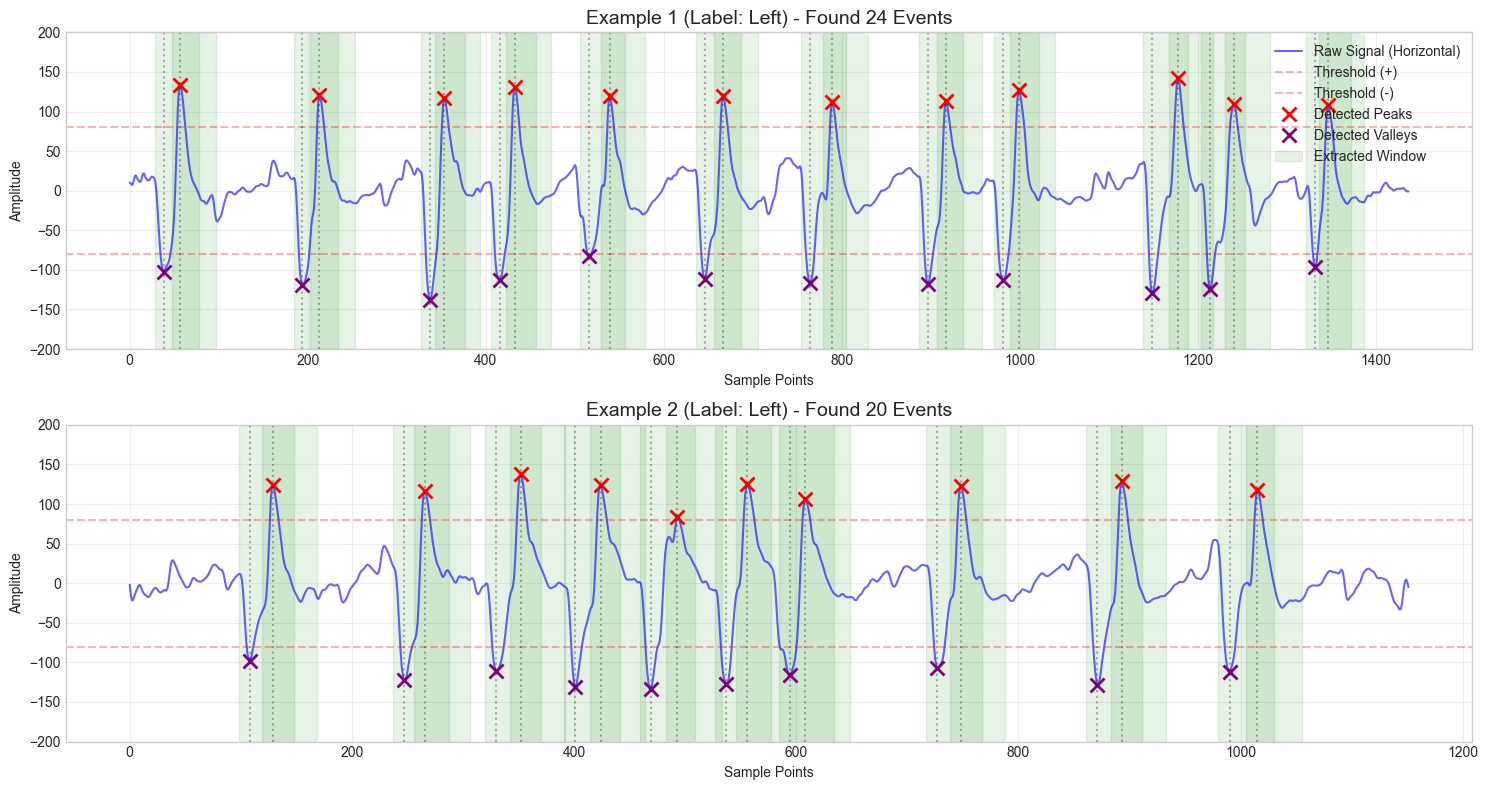

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

def visualize_peak_detection_process(data_list, label_list, target_label_name="Left", num_examples=3):
    """
    可视化峰值检测过程：画出长波形，标记峰值，画出切分窗口。
    """
    # 找到目标类别的索引
    target_idx = CLASSES.index(target_label_name)
    
    # 筛选出该类别的所有数据
    indices = [i for i, x in enumerate(label_list) if x == target_idx]
    
    if len(indices) == 0:
        print(f"没有找到 {target_label_name} 的数据！")
        return

    # 随机选几个文件展示
    chosen_indices = indices[:num_examples]
    
    # 参数设置 (必须与 segment_data_by_peaks 保持一致)
    HEIGHT_THRES = 80
    DISTANCE = 40
    PRE_BUFFER = 10
    WINDOW_SIZE = 50
    
    plt.figure(figsize=(15, 4 * len(chosen_indices)))
    
    for i, idx in enumerate(chosen_indices):
        data = data_list[idx]
        
        # 假设 Left 主要看 Horizontal (data[:, 0])
        # 如果是 Up/Down/Blink，你可能需要改看 Vertical (data[:, 1])
        # 为了通用，我们这里只画 Horizontal 通道演示
        signal = data[:, 0] 
        
        # 1. 找正峰值 (模拟代码逻辑)
        peaks, _ = find_peaks(signal, height=HEIGHT_THRES, distance=DISTANCE)
        
        # 2. 找负峰值 (模拟代码逻辑)
        valleys, _ = find_peaks(-signal, height=HEIGHT_THRES, distance=DISTANCE)
        
        # 合并
        all_peaks = np.concatenate([peaks, valleys])
        all_peaks = np.sort(all_peaks)
        
        # --- 开始画图 ---
        ax = plt.subplot(len(chosen_indices), 1, i+1)
        ax.plot(signal, label='Raw Signal (Horizontal)', color='blue', alpha=0.6)
        
        # 画阈值线
        ax.axhline(y=HEIGHT_THRES, color='r', linestyle='--', alpha=0.3, label='Threshold (+)')
        ax.axhline(y=-HEIGHT_THRES, color='r', linestyle='--', alpha=0.3, label='Threshold (-)')
        
        # 标记每一个找到的峰值
        ax.plot(peaks, signal[peaks], "x", color='red', markersize=10, markeredgewidth=2, label='Detected Peaks')
        ax.plot(valleys, signal[valleys], "x", color='purple', markersize=10, markeredgewidth=2, label='Detected Valleys')

        # 画出切分窗口 (模拟)
        for p in all_peaks:
            start_x = p - PRE_BUFFER 
            end_x = start_x + WINDOW_SIZE
            
            # 画一个半透明的绿色方块，代表被模型吃掉的窗口
            ax.axvspan(start_x, end_x, color='green', alpha=0.1, label='Extracted Window' if p == all_peaks[0] else "")
            
            # 画一个垂直虚线，代表峰值中心
            ax.axvline(x=p, color='black', linestyle=':', alpha=0.3)
            
        ax.set_title(f"Example {i+1} (Label: {target_label_name}) - Found {len(all_peaks)} Events", fontsize=14)
        ax.set_xlabel("Sample Points")
        ax.set_ylabel("Amplitude")
        if i == 0: ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-200, 200)

    plt.tight_layout()
    plt.show()

# 🚀 试试看！
# 修改 "Left" 成 "Right" / "Up" / "Down" / "Blink" 来查看不同动作的切分逻辑
visualize_peak_detection_process(X_filtered_list, y_raw_list, target_label_name="Left", num_examples=2)

# Module 5: 模型训练与对比 (Model Comparison)

Training Random Forest...
--> Random Forest Accuracy: 0.8857
Training SVM (RBF)...
--> SVM (RBF) Accuracy: 0.8240
Training KNN (k=5)...
--> KNN (k=5) Accuracy: 0.8270


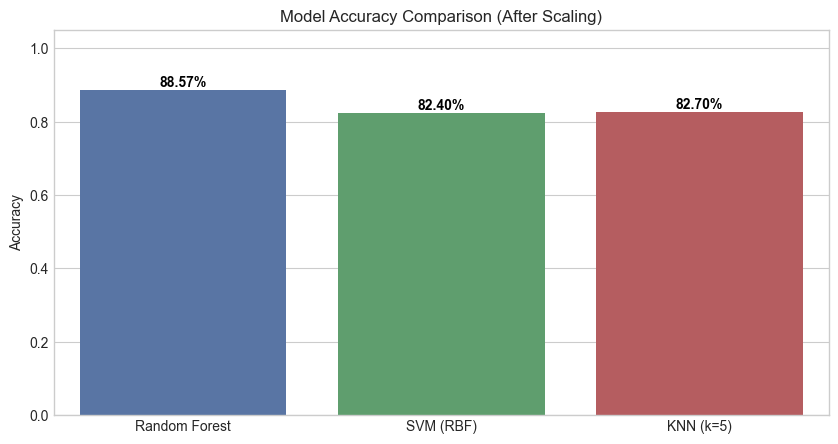

In [12]:
# Cell 5: Model Training & Comparison (Fixed)

from sklearn.preprocessing import StandardScaler

# 1. 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. [关键步骤] 特征归一化 (Standardization)
# 这一步对于 SVM 和 KNN 至关重要！
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # 注意：测试集只能 transform，不能 fit

# 3. 定义模型
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # 树模型(RF)其实不需要缩放，但缩放了也没坏处
    # SVM 和 KNN 必须用缩放后的数据 (X_train_scaled)
    if name == "Random Forest":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"--> {name} Accuracy: {acc:.4f}")

# 4. 画图 (修复坐标轴)
plt.figure(figsize=(10, 5))
# 使用不同的颜色
colors = ['#4c72b0', '#55a868', '#c44e52']
barplot = sns.barplot(x=list(results.keys()), y=list(results.values()), palette=colors)

# 在柱子上方显示具体数值
for i, v in enumerate(results.values()):
    barplot.text(i, v + 0.01, f'{v:.2%}', ha='center', color='black', fontweight='bold')

plt.ylim(0.0, 1.05) # 设置 Y 轴为 0 到 1.05，确保所有柱子都能看见
plt.title("Model Accuracy Comparison (After Scaling)")
plt.ylabel("Accuracy")
plt.show()

Training Random Forest...
--> Random Forest Accuracy: 0.8909
Training SVM...
--> SVM Accuracy: 0.8636

🔍 Best Model Report:
              precision    recall  f1-score   support

        Rest       1.00      1.00      1.00        71
          Up       0.82      0.73      0.77        37
        Down       0.79      0.92      0.85        36
        Left       0.88      0.88      0.88        26
       Right       0.92      0.88      0.90        26
       Blink       0.83      0.79      0.81        24

    accuracy                           0.89       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.89      0.89      0.89       220



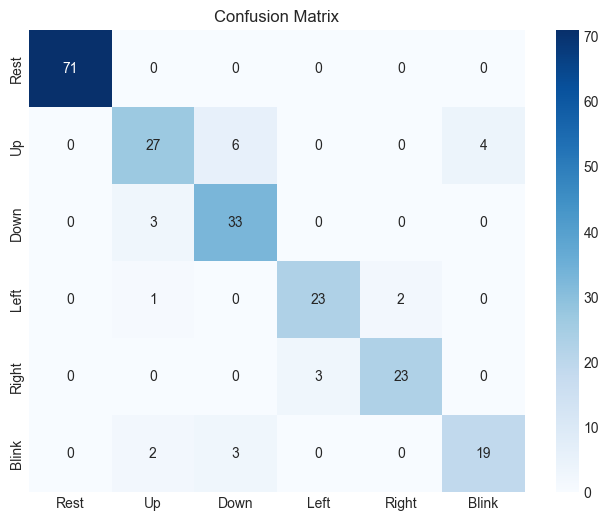

In [16]:
# 1. 数据划分
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# 2. 【核心关键】归一化 (Standardization)
# 训练集 fit_transform, 测试集 transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 定义模型
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# 4. 训练与评估
best_model = None
best_acc = 0

for name, model in models.items():
    print(f"Training {name}...")
    # 注意：所有模型都使用 SCALED 数据训练！
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"--> {name} Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_model = model

# 5. 混淆矩阵 (查看 Rest 是否还有误判)
print("\n🔍 Best Model Report:")
y_pred_final = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_final, target_names=CLASSES))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.show()

# Module 6: 深度评估与误触分析 (Evaluation)

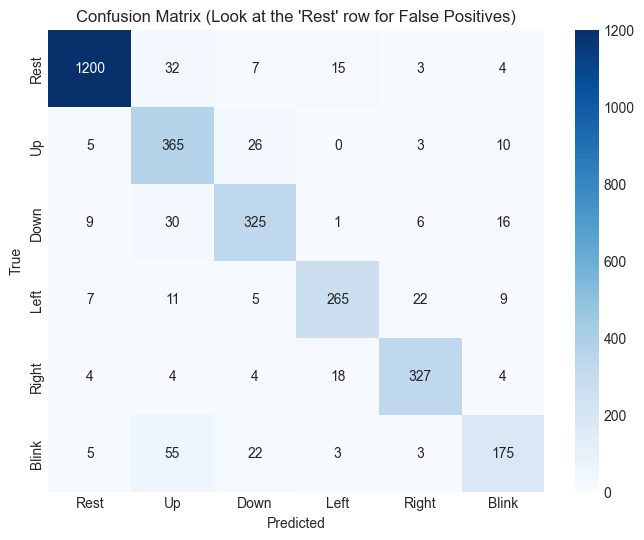

              precision    recall  f1-score   support

        Rest       0.98      0.95      0.96      1261
          Up       0.73      0.89      0.81       409
        Down       0.84      0.84      0.84       387
        Left       0.88      0.83      0.85       319
       Right       0.90      0.91      0.90       361
       Blink       0.80      0.67      0.73       263

    accuracy                           0.89      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.89      0.89      0.89      3000

Total False Positives (Rest predicted as Action): 61
Visualizing some False Positive examples...


In [17]:
# Cell 6: Detailed Evaluation (Focus on False Positives)

# 选出表现最好的模型 (通常是 Random Forest)
best_model = models["Random Forest"]
y_pred = best_model.predict(X_test)

# 1. 混淆矩阵
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix (Look at the 'Rest' row for False Positives)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. 打印分类报告
print(classification_report(y_test, y_pred, target_names=CLASSES))

# 3. 误触分析：找出那些本来是 Rest 但被预测成动作的样本
false_positives = np.where((y_test == 0) & (y_pred != 0))[0] # 0 is Rest

print(f"Total False Positives (Rest predicted as Action): {len(false_positives)}")

if len(false_positives) > 0:
    print("Visualizing some False Positive examples...")
    # 随机看几个误触的样本特征（虽然这里看不到原始波形，但能看到特征分布）
    # 如果你想看原始波形，需要在切片时保留索引，这比较复杂，现阶段先看数量。
else:
    print("Excellent! No False Positives in the test set.")

# Module 7: 保存最佳模型

In [16]:
# Cell 7: Save Model
import joblib
joblib.dump(best_model, 'eog_model_v2.joblib')
joblib.dump(scaler, 'eog_scaler.joblib')
print("Model and scaler saved as eog_model_v2.joblib, and eog_scaler.joblib")

Model and scaler saved as eog_model_v2.joblib, and eog_scaler.joblib


In [21]:
# 保存模型和 Scaler
# 这一步非常重要，实时代码需要这两个文件
print(f"💾 Saving best model ({best_acc:.2%})...")
joblib.dump(best_model, 'eog_model_v4.joblib')
joblib.dump(scaler, 'eog_scaler_v4.joblib')
print("✅ Saved 'eog_model_v4.joblib' and 'eog_scaler_v4.joblib' successfully!")

💾 Saving best model (89.09%)...
✅ Saved 'eog_model_v4.joblib' and 'eog_scaler_v4.joblib' successfully!


## 模拟数据

🚀 Generating simulated data from existing segments...
✅ Simulated file saved to: data/EOG_data/Test_Simulated/Simulated_01.csv


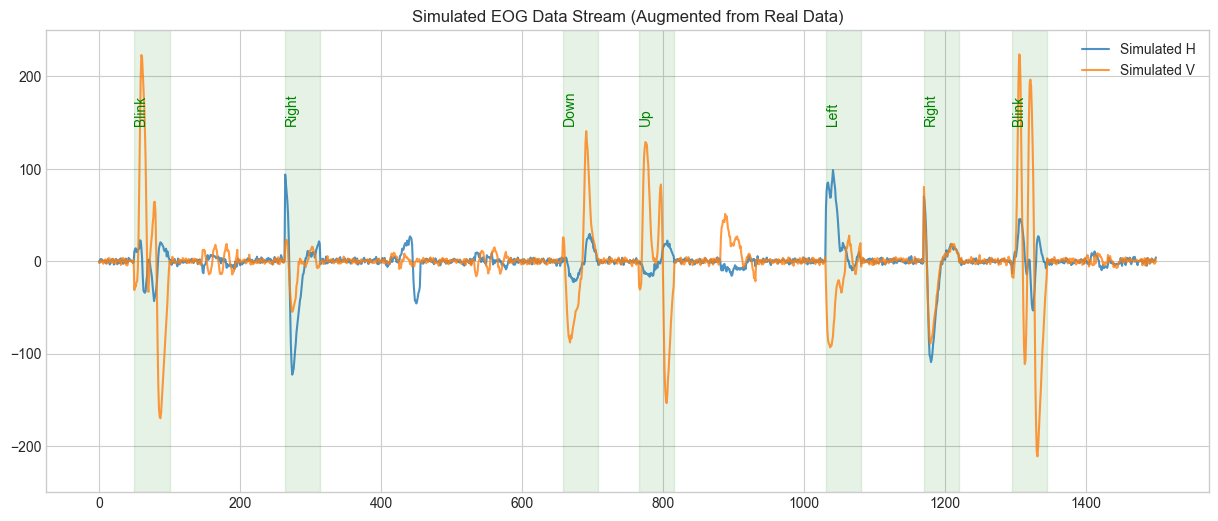

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ==== 配置 ====
OUTPUT_FILE = "data/EOG_data/Test_Simulated/Simulated_01.csv" # 保存路径
DURATION_SECONDS = 30  # 模拟生成 30 秒的数据
FS = 50                # 采样率
TOTAL_POINTS = DURATION_SECONDS * FS
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]

# 确保输出目录存在
import os
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

# ==== 1. 数据增强工具箱 ====
def augment_segment(segment):
    """给完美的片段加点料，让它看起来不那么完美"""
    # A. 随机幅度缩放 (0.8 ~ 1.2 倍)
    scale = np.random.uniform(0.8, 1.2)
    aug_seg = segment * scale
    
    # B. 随机加噪 (±2 的抖动)
    noise = np.random.normal(0, 2, segment.shape)
    aug_seg = aug_seg + noise
    
    return aug_seg

# ==== 2. 生成器核心 ====
def generate_mock_stream(X_pool, y_pool):
    # 初始化两条平直的基线 (全是 0)
    # 加上一些基础的背景底噪 (Base Noise)
    h_channel = np.random.normal(0, 2, TOTAL_POINTS)
    v_channel = np.random.normal(0, 2, TOTAL_POINTS)
    
    # 记录真实标签，方便对比验证
    ground_truth = [] 
    
    current_idx = 50 # 从第 1 秒开始放动作
    
    while current_idx < TOTAL_POINTS - 100:
        # 1. 随机决定下一个动作是什么
        # 50% 概率是 Rest (发呆)，50% 概率是某个动作
        if random.random() < 0.3:
            action_idx = 0 # Rest
            action_name = "Rest"
        else:
            # 随机选一个非 Rest 的动作
            action_idx = random.choice([1, 2, 3, 4, 5]) 
            action_name = CLASSES[action_idx]
            
        # 2. 从素材库里找一个该动作的真实样本
        # 找到所有属于该类别的样本索引
        candidate_indices = np.where(y_pool == action_idx)[0]
        
        if len(candidate_indices) > 0:
            # 随机选一个
            chosen_idx = np.random.choice(candidate_indices)
            real_segment = X_pool[chosen_idx] # Shape: (50, 2)
            
            # 3. 进行数据增强
            final_segment = augment_segment(real_segment)
            
            # 4. 粘贴到时间轴上
            end_idx = current_idx + 50
            if end_idx >= TOTAL_POINTS: break
            
            # 叠加到背景上 (注意：要处理好边界衔接，这里直接覆盖)
            h_channel[current_idx:end_idx] = final_segment[:, 0]
            v_channel[current_idx:end_idx] = final_segment[:, 1]
            
            # 记录这次动作的信息
            ground_truth.append({
                "time": current_idx / FS,
                "label": action_name,
                "start_idx": current_idx,
                "end_idx": end_idx
            })
            
            # 5. 决定下一个动作什么时候开始
            # 动作做完后，随机休息 0.5秒 ~ 2秒
            rest_gap = np.random.randint(25, 100)
            current_idx = end_idx + rest_gap
            
        else:
            # 如果素材库里没有这个动作，就跳过
            current_idx += 50

    return np.column_stack((h_channel, v_channel)), ground_truth

# ==== 3. 执行生成 ====
# 注意：这里需要你之前已经跑过 segment_data_by_peaks_final 并生成了 X_segments, y_segments
if 'X_segments' in locals() and len(X_segments) > 0:
    print("🚀 Generating simulated data from existing segments...")
    mock_data, truth_log = generate_mock_stream(X_segments, y_segments)
    
    # ==== 4. 保存为 CSV ====
    # 构造时间戳列
    time_col = np.linspace(0, DURATION_SECONDS, TOTAL_POINTS)
    df_mock = pd.DataFrame({
        'Program Time [s]': time_col,
        'data 0': mock_data[:, 0], # H
        'data 1': mock_data[:, 1]  # V
    })
    
    df_mock.to_csv(OUTPUT_FILE, index=False)
    print(f"✅ Simulated file saved to: {OUTPUT_FILE}")
    
    # ==== 5. 画出来看看 ====
    plt.figure(figsize=(15, 6))
    plt.plot(mock_data[:, 0], label='Simulated H', alpha=0.8)
    plt.plot(mock_data[:, 1], label='Simulated V', alpha=0.8)
    
    # 标记真实动作位置
    for item in truth_log:
        if item['label'] != 'Rest':
            plt.axvspan(item['start_idx'], item['end_idx'], color='green', alpha=0.1)
            plt.text(item['start_idx'], 150, item['label'], rotation=90, color='green')
            
    plt.title("Simulated EOG Data Stream (Augmented from Real Data)")
    plt.ylim(-250, 250)
    plt.legend()
    plt.show()
    
else:
    print("❌ Error: 请先运行上面的代码生成 X_segments 和 y_segments！")

⏳ Loading model & scaler...
✅ Ready.
📄 Loaded 1500 points from Simulated_01.csv
✂️ Auto-segmenting active events...
✅ Detected 6 potential actions.

🧐 Visual Verification (Please check manually):


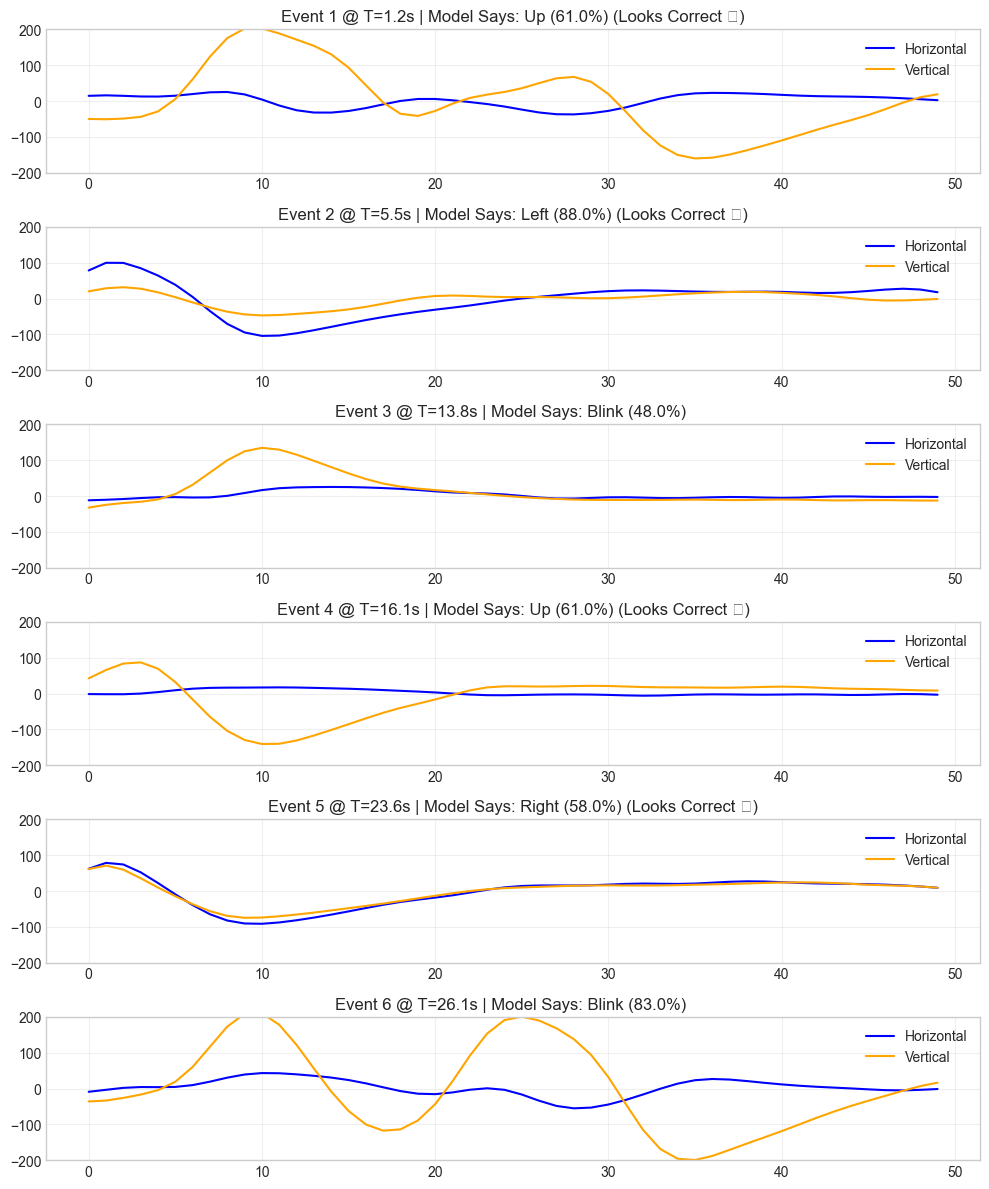

In [23]:
import joblib
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ==== 1. 配置 ====
TEST_FILE_PATH = "data/EOG_data/Test_Simulated/Simulated_01.csv" 
MODEL_PATH = 'eog_model_v4.joblib'
SCALER_PATH = 'eog_scaler_v4.joblib'

# 参数
WINDOW_SIZE = 50
TARGET_FS = 50
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]

# ==== 2. 加载模型 ====
print("⏳ Loading model & scaler...")
clf = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
print("✅ Ready.")

# ==== 3. 通用切分函数 (Blind Segmentation) ====
def segment_unknown_stream(data):
    """
    不依赖标签，查找所有显著的动作片段
    """
    segments = []
    timestamps = [] # 记录切分点，方便画图
    
    HEIGHT_THRES = 80  # 动作阈值
    DISTANCE = 45      # 两个动作之间的最小距离 (防止重复切)
    PRE_BUFFER = 10    # 峰值前留多少点
    
    # 1. 计算 H 和 V 的绝对值信号 (这样正负峰都能变成正的)
    abs_h = np.abs(data[:, 0])
    abs_v = np.abs(data[:, 1])
    
    # 2. 在绝对值上找峰值 (只要动静大，不管方向)
    peaks_h, _ = find_peaks(abs_h, height=HEIGHT_THRES, distance=DISTANCE)
    peaks_v, _ = find_peaks(abs_v, height=HEIGHT_THRES, distance=DISTANCE)
    
    # 3. 合并 H 和 V 的峰值，并去重排序
    all_peaks = np.concatenate([peaks_h, peaks_v])
    all_peaks = np.unique(np.sort(all_peaks))
    
    # 4. 过滤靠得太近的峰值 (简单的非极大值抑制)
    final_peaks = []
    if len(all_peaks) > 0:
        last_peak = all_peaks[0]
        final_peaks.append(last_peak)
        for p in all_peaks[1:]:
            if p - last_peak > DISTANCE:
                final_peaks.append(p)
                last_peak = p
            # else: 忽略这个峰，因为它离上一个太近了，可能是同一个动作的余波
            
    # 5. 执行切分
    for p in final_peaks:
        start_idx = p - PRE_BUFFER
        end_idx = start_idx + WINDOW_SIZE
        
        if start_idx < 0 or end_idx > len(data):
            continue
            
        window = data[start_idx:end_idx]
        segments.append(window)
        timestamps.append(p)
        
    return np.array(segments), timestamps

# ==== 4. 数据预处理 ====
# 读取 CSV
df = pd.read_csv(TEST_FILE_PATH)
raw_data = df[['data 0', 'data 1']].values # 假设模拟数据已经是 50Hz，不需要重采样
print(f"📄 Loaded {len(raw_data)} points from {os.path.basename(TEST_FILE_PATH)}")

# 滤波 (模拟实时环境)
# 简单的带通滤波函数 (复用你之前的逻辑)
from scipy import signal
def simple_filter(data):
    b, a = signal.butter(4, [0.5/25, 10.0/25], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

filtered_data = simple_filter(raw_data)

# ==== 5. 执行“盲测” ====
print("✂️ Auto-segmenting active events...")
X_segments, cut_points = segment_unknown_stream(filtered_data)

if len(X_segments) == 0:
    print("❌ 没有检测到任何动作！请检查阈值或数据文件。")
else:
    print(f"✅ Detected {len(X_segments)} potential actions.")
    
    # 特征提取 (复用之前的逻辑)
    # 注意：这里我们手动把 label 设为 0，反正预测时不看 label
    dummy_labels = np.zeros(len(X_segments)) 
    
    # 使用你之前定义的 extract_features_and_filter 
    # (确保那个函数在内存里，或者把它的逻辑考过来)
    # 这里为了演示简单，我直接手写核心特征提取逻辑
    X_feats = []
    for window in X_segments:
        feats = []
        for axis in range(2):
            sig = window[:, axis]
            sig = sig - np.mean(sig) # 去直流
            feats.append(np.std(sig))
            feats.append(np.max(sig) - np.min(sig))
            feats.append(np.mean(sig))
            feats.append(np.max(sig))
            feats.append(np.min(sig))
            diff = np.diff(sig)
            feats.append(np.mean(np.abs(diff)))
            feats.append(np.max(np.abs(diff)))
        X_feats.append(feats)
    
    X_feats = np.array(X_feats)
    
    # 归一化
    X_scaled = scaler.transform(X_feats)
    
    # 预测
    preds = clf.predict(X_scaled)
    probs = clf.predict_proba(X_scaled)
    
    # ==== 6. 可视化验证 (人工判卷) ====
    # 因为我们没有 Ground Truth (除非你去解析 log)，所以最好的验证方式是：
    # 画出波形，标题写上"模型预测结果"，你自己看来判断对不对。
    
    print("\n🧐 Visual Verification (Please check manually):")
    
    # 每次展示 3 个结果，分批展示
    fig, axes = plt.subplots(len(preds), 1, figsize=(10, 2 * len(preds)))
    if len(preds) == 1: axes = [axes] # 兼容只有一个结果的情况
    
    for i, ax in enumerate(axes):
        window = X_segments[i]
        pred_label = CLASSES[preds[i]]
        confidence = np.max(probs[i])
        
        # 简单规则判断是否正确 (仅供参考)
        # 比如：如果预测是 Left，那么 H 通道应该是正的大波峰
        guess_hint = ""
        h_max = np.max(window[:, 0] - np.mean(window[:, 0]))
        h_min = np.min(window[:, 0] - np.mean(window[:, 0]))
        
        if pred_label == "Left" and h_max > 50: guess_hint = "(Looks Correct ✅)"
        elif pred_label == "Right" and h_min < -50: guess_hint = "(Looks Correct ✅)"
        elif pred_label == "Up" and np.max(window[:, 1]) > 50: guess_hint = "(Looks Correct ✅)"
        
        ax.plot(window[:, 0], label='Horizontal', color='blue')
        ax.plot(window[:, 1], label='Vertical', color='orange')
        ax.set_title(f"Event {i+1} @ T={cut_points[i]/50:.1f}s | Model Says: {pred_label} ({confidence:.1%}) {guess_hint}")
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-200, 200)
        
    plt.tight_layout()
    plt.show()

## 静态检测

⏳ Loading model...

🔍 Analyzing: Real_Test_Left.csv


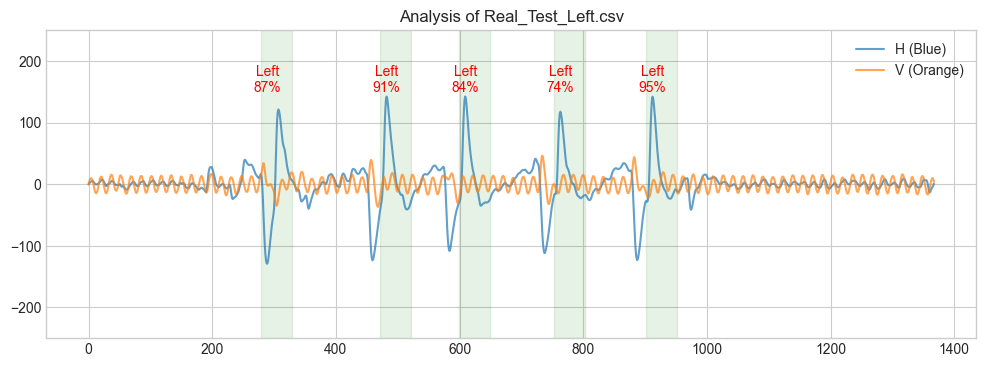


🔍 Analyzing: Real_Test_Right.csv


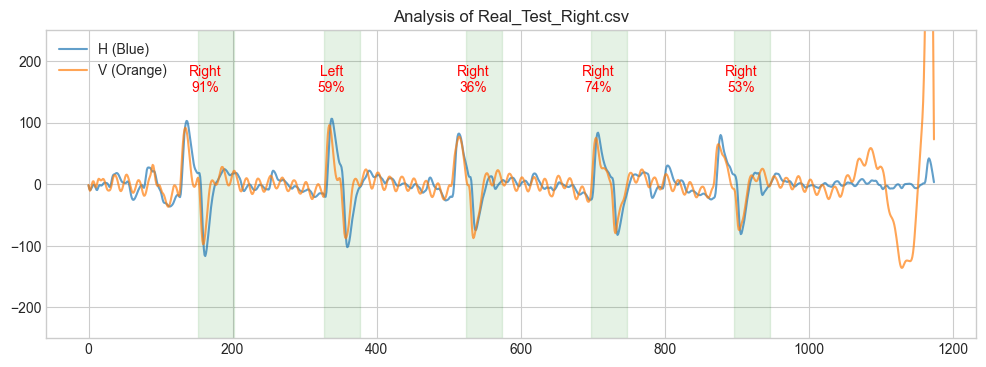


🔍 Analyzing: Real_Test_Up.csv


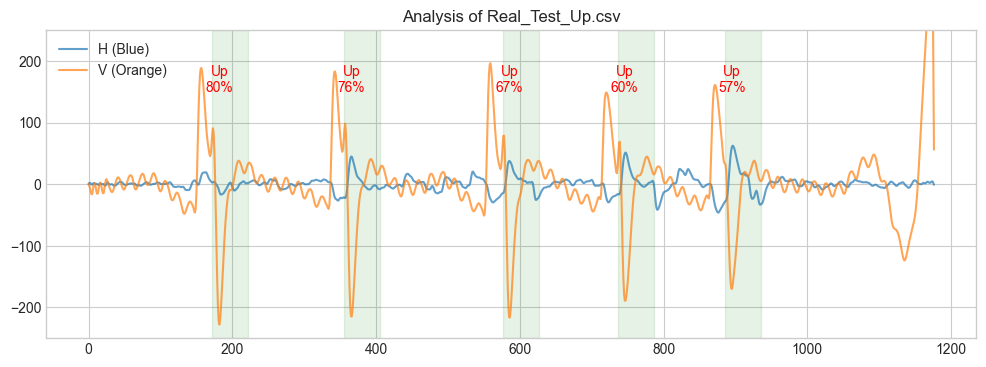


🔍 Analyzing: Real_Test_Down.csv


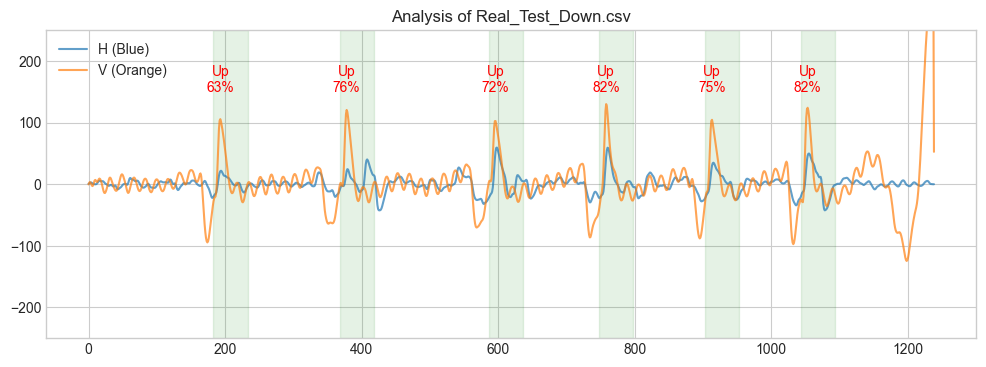


🔍 Analyzing: Real_Test_Blink.csv


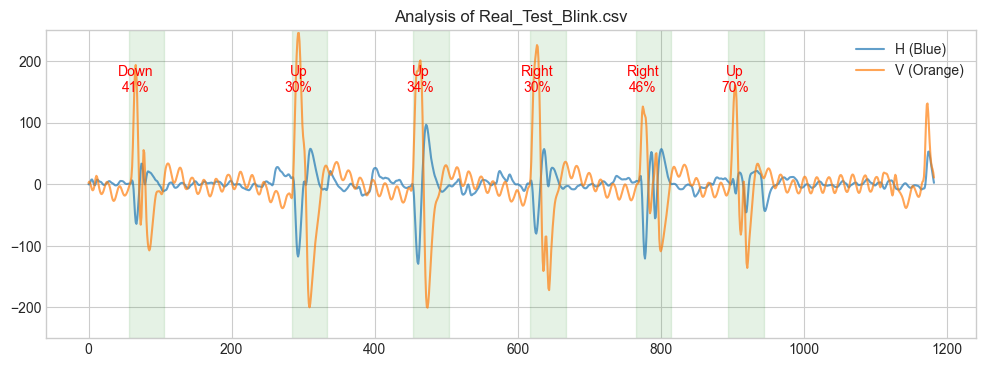

In [26]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks
import os

# ==== 1. 配置区域 ====
# ⚠️ 把这里改成你刚刚录制的真实文件路径
TEST_FILES = [
    "EOG_data/Real_Test/Real_Test_Left.csv",
    "EOG_data/Real_Test/Real_Test_Right.csv",
    "EOG_data/Real_Test/Real_Test_Up.csv",
"EOG_data/Real_Test/Real_Test_Down.csv", "EOG_data/Real_Test/Real_Test_Blink.csv",
    # ... 把你录的文件都放这里
]

MODEL_PATH = 'eog_model_v4.joblib'
SCALER_PATH = 'eog_scaler_v4.joblib'
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]

# ==== 2. 加载模型 ====
print("⏳ Loading model...")
clf = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# ==== 3. 辅助函数 ====
def simple_process(filepath):
    """读取 -> 滤波 -> 盲测切分"""
    # A. 读取
    try:
        df = pd.read_csv(filepath, header=0, usecols=['data 0', 'data 1']) # 假设是这两列
    except:
        # 兼容 OpenBCI GUI 格式或不带表头的格式，根据实际情况调整
        df = pd.read_csv(filepath, header=None).iloc[:, [1, 2]] 
        
    raw_data = df.values
    
    # B. 滤波 (0.5-10Hz)
    b, a = signal.butter(4, [0.5/25, 10.0/25], btype='band')
    filtered_data = signal.filtfilt(b, a, raw_data, axis=0)
    
    # C. 盲测切分 (找幅度>80的动作)
    segments = []
    timestamps = []
    
    # 取绝对值找峰
    energy = np.max(np.abs(filtered_data), axis=1)
    peaks, _ = find_peaks(energy, height=80, distance=50)
    
    for p in peaks:
        start = p - 10
        end = start + 50
        if start < 0 or end > len(filtered_data): continue
        segments.append(filtered_data[start:end])
        timestamps.append(p)
        
    return np.array(segments), timestamps, filtered_data

# ==== 4. 批量验证 & 画图 ====
for fpath in TEST_FILES:
    if not os.path.exists(fpath):
        print(f"⚠️ 文件不存在: {fpath} (跳过)")
        continue
        
    print(f"\n🔍 Analyzing: {os.path.basename(fpath)}")
    X_seg, time_pts, full_wave = simple_process(fpath)
    
    if len(X_seg) == 0:
        print("❌ 未检测到大幅度动作 (可能是阈值太高或动作太轻)")
        continue
        
    # 特征提取 & 预测
    X_feats = []
    for w in X_seg:
        feats = []
        for axis in range(2):
            sig = w[:, axis]
            sig = sig - np.mean(sig) # 去直流
            feats.append(np.std(sig))
            feats.append(np.max(sig) - np.min(sig))
            feats.append(np.mean(sig))
            feats.append(np.max(sig))
            feats.append(np.min(sig))
            diff = np.diff(sig)
            feats.append(np.mean(np.abs(diff)))
            feats.append(np.max(np.abs(diff)))
        X_feats.append(feats)
        
    # 预测
    preds = clf.predict(scaler.transform(X_feats))
    probs = clf.predict_proba(scaler.transform(X_feats))
    
    # ==== 画图展示结果 ====
    plt.figure(figsize=(12, 4))
    plt.plot(full_wave[:, 0], label='H (Blue)', alpha=0.7)
    plt.plot(full_wave[:, 1], label='V (Orange)', alpha=0.7)
    
    # 在图上标记模型预测的结果
    for i, t in enumerate(time_pts):
        label = CLASSES[preds[i]]
        conf = np.max(probs[i])
        
        # 你的"修正补丁"逻辑可以在脑子里运行：
        # 如果你录的是 Left 文件，但这里显示 Right，那你就知道实时代码里要加个 if 改过来
        
        plt.axvspan(t-10, t+40, color='green', alpha=0.1)
        plt.text(t, 150, f"{label}\n{conf:.0%}", color='red', fontsize=10, ha='center')
        
    plt.title(f"Analysis of {os.path.basename(fpath)}")
    plt.legend()
    plt.ylim(-250, 250)
    plt.show()